In [2]:
conda install pytorch torchvision -c pytorch

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install transformers

     |████████████████████████████████| 2.9 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 28.9 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 18.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#In particular, for each paper identified from exercise 1, compute the SPECTER embedding (a 768-dimensional vector). 
#Keep track of which papers came from searching for Alzheimers, which came from searching for cancer. 

In [40]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')


In [5]:
import json
import numpy as np
import pandas as pd

In [41]:
f = open('pb2000.json')
papers = json.load(f)

In [42]:
data = []
for paper in papers.values():
    data += [paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"]]
    
inputs = tokenizer(data[0], padding=True, truncation=True, return_tensors="pt", max_length=512)
result = model(**inputs)
# take the first token in the batch as the embedding
embeddings_total = result.last_hidden_state[:, 0, :].detach().numpy()

for i in range(1,len(data)):
    inputs = tokenizer(data[i], padding=True, truncation=True, return_tensors="pt", max_length=512)
    result = model(**inputs)
    embeddings = result.last_hidden_state[:, 0, :].detach().numpy()
    embeddings_total = np.concatenate((embeddings_total,embeddings),axis=0)

In [43]:
#Find the index of the overlap paper.
paper_list = list(papers)
for i in range(len(paper_list)):
    if paper_list[i] =="32501203":
        print(i)

885


In [44]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings_total),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["Query"] = [paper["Query"][0] for paper in papers.values()]
embeddings_pca.loc[885,"Query"] = 'BOTH'#Name the overlap paper as "Both" #https://www.geeksforgeeks.org/python-pandas-dataframe-loc/

In [45]:
embeddings_pca

,PC0,PC1,PC2,Query
0,-4.686102,-4.797193,-1.501220,CANCER
1,4.000983,-2.101142,-3.992321,CANCER
2,1.513947,-3.910135,-4.383604,CANCER
3,3.747759,-0.245759,-4.093632,CANCER
4,2.980736,-3.004155,-5.297383,CANCER
...,...,...,...,...
1994,-4.649996,-0.426457,-0.557408,ALZHEIMERS
1995,-4.186847,-0.315715,1.904060,ALZHEIMERS
1996,-8.014501,0.748415,3.851795,ALZHEIMERS
1997,-7.775526,-2.819993,-0.221032,ALZHEIMERS


In [46]:
embeddings_pca.loc[885,"Query"]

'BOTH'

In [50]:
embeddings_pca.loc[999,"Query"]

'CANCER'

In [63]:
embeddings_pca.loc[1000,"Query"]

'ALZHEIMERS'

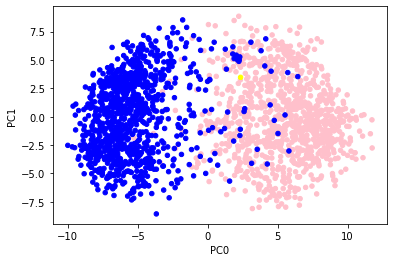

In [52]:
embeddings_pca.plot.scatter(x = 'PC0', y = 'PC1', c=embeddings_pca.Query.map(dict(ALZHEIMERS='blue', CANCER='pink',BOTH = 'yellow')));

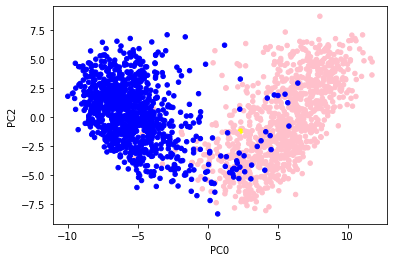

In [53]:
embeddings_pca.plot.scatter(x = 'PC0', y = 'PC2', c=embeddings_pca.Query.map(dict(ALZHEIMERS='blue', CANCER='pink',BOTH = 'yellow')));

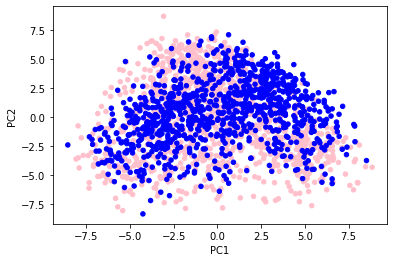

In [54]:
embeddings_pca.plot.scatter(x = 'PC1', y = 'PC2', c=embeddings_pca.Query.map(dict(ALZHEIMERS='blue', CANCER='pink',BOTH = 'yellow')));

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [71]:
l = []
for i in range(885):# From index 0-884 the paper is Cancer, tag as 1 
    l.append(1)
l.append(2) #The overlap, tag as 2
for i in range(114):#From 886-999 the paper is Cancer, still tag as 1
    l.append(1) 
for i in range(999):#From index 1000-1998 are Alzheimers, tag as 0
    l.append(0)
total = np.array(l)

lda = LDA(n_components=2)   
embeddings_lda = pd.DataFrame(
    lda.fit_transform(embeddings_total,total),
    columns=['LD0','LD1']
)

embeddings_lda["Query"] = [paper["Query"][0] for paper in papers.values()]
embeddings_lda.loc[885,"Query"] = 'BOTH'

In [72]:
embeddings_lda

,LD0,LD1,Query
0,2.075702,1.164759,CANCER
1,3.819197,-0.315971,CANCER
2,3.798645,0.861194,CANCER
3,2.895172,-0.432372,CANCER
4,4.449149,-0.713219,CANCER
...,...,...,...
1994,-2.163132,-0.797396,ALZHEIMERS
1995,-3.535121,-2.088272,ALZHEIMERS
1996,-4.141159,-1.050867,ALZHEIMERS
1997,-4.080945,0.309695,ALZHEIMERS


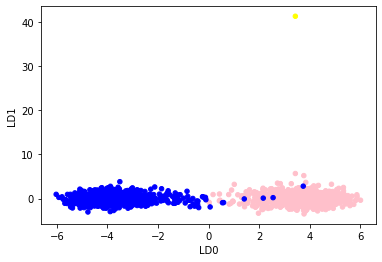

In [74]:
embeddings_lda.plot.scatter(x = 'LD0', y = 'LD1', c=embeddings_lda.Query.map(dict(ALZHEIMERS='blue', CANCER='pink',BOTH = 'yellow')));